# Intro to  Linear Regression with cuML
Corresponding notebook to [*Beginner’s Guide to Linear Regression in Python with cuML*](http://bit.ly/cuml_lin_reg_friend) story on Medium

Linear Regression is a simple machine learning model where the response `y` is modelled by a linear combination of the predictors in `X`. The `LinearRegression` function implemented in the `cuML` library allows users to change the `fit_intercept`, `normalize`, and `algorithm` parameters. 

Here is a brief on RAPIDS' Linear Regression parameters:

- `algorithm`: 'eig' or 'svd' (default = 'eig')
    - `Eig` uses a eigen decomposition of the covariance matrix, and is much faster
    - `SVD` is slower, but guaranteed to be stable
- `fit_intercept`: boolean (default = True)
  - If `True`, `LinearRegresssion` tries to correct for the global mean of `y`
  - If `False`, the model expects that you have centered the data.
- `normalize`: boolean (default = False)
  - If True, the predictors in X will be normalized by dividing by it’s L2 norm
  - If False, no scaling will be done

Methods that can be used with `LinearRegression` are:

- `fit`: Fit the model with `X` and `y`
- `get_params`: Sklearn style return parameter state
- `predict`: Predicts the `y` for `X`
- `set_params`: Sklearn style set parameter state to dictionary of params

`cuML`'s `LinearRegression` expects expects either `cuDF` DataFrame or `NumPy` matrix inputs



Note: `CuPy` is not installed by default with RAPIDS `Conda` or `Docker` packages, but is needed for visualizing results in this notebook.
- install with `pip` via the cell below 

In [1]:
# install cupy
# !pip install cupy

try:
    import cupy
except ModuleNotFoundError:
    os.system('conda install -c rapidsai -y cupy') 
# try:
#     import cuxfilter
# except ModuleNotFoundError:
#     os.system('conda install -c rapidsai cuxfilter')   
import cuxfilter
from cuxfilter.charts import scatter
from cuxfilter import DataFrame, themes, layouts
from cuxfilter.assets.custom_tiles import get_provider, Vendors


!conda list

# packages in environment at /opt/conda/envs/rapids:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       1_gnu    conda-forge
abseil-cpp                20210324.0           h9c3ff4c_0    conda-forge
aiohttp                   3.7.4            py37h5e8e339_0    conda-forge
alsa-lib                  1.2.3                h516909a_0    conda-forge
anyio                     2.2.0            py37h89c1867_0    conda-forge
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
argon2-cffi               20.1.0           py37h5e8e339_2    conda-forge
arrow-cpp                 1.0.1           py37h363ccdf_36_cuda    conda-forge
arrow-cpp-proc            3.0.0                      cuda    conda-forge
async-timeout             3.0.1                   py_1000    conda-forge
async_generator           1.10                       py_0    conda-for

## Load data
- for this demo, we will be utilizing the Boston housing dataset from `sklearn`
  - start by loading in the set and printing a map of the contents

In [2]:
from sklearn.datasets import load_boston

# load Boston dataset
boston = load_boston()

# let's see what's inside
print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


#### Boston house prices dataset
- a description of the dataset is provided in `DESCR`
  - let's explore 

In [3]:
# what do we know about this dataset?
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### Build Dataframe
- Import `cuDF` and input the data into a DataFrame 
  - Then add a `PRICE` column equal to the `target` key

In [4]:
import cudf

# build dataframe from data key
bos = cudf.DataFrame(list(boston.data))
# set column names to feature_names
bos.columns = boston.feature_names

# add PRICE column from target
bos['PRICE'] = boston.target

# let's see what we're working with
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Split Train from Test
- For basic Linear Regression, we will predict `PRICE` (Median value of owner-occupied homes) based on `TAX` (full-value property-tax rate per $10,000)
  - Go ahead and trim data to just these columns

In [5]:
# simple linear regression X and Y
X = bos['TAX']
Y = bos['PRICE']

We can now set training and testing sets for our model
- Use `cuML`'s `train_test_split` to do this
  - Train on 70% of data
  - Test on 30% of data

In [6]:
from cuml.preprocessing.model_selection import train_test_split

# train/test split (70:30)
sX_train, sX_test, sY_train, sY_test = train_test_split(X, Y, train_size = 0.7)

# see what it looks like
print(sX_train.shape)
print(sX_test.shape)
print(sY_train.shape)
print(sY_test.shape)

(354,)
(152,)
(354,)
(152,)


### Predict Values
1. fit the model with `TAX` (*X_train*) and corresponding `PRICE` (*y_train*) values 
  - so it can build an understanding of their relationship 
2. predict `PRICE` (*y_test*) for a test set of `TAX` (*X_test*) values
  - and compare `PRICE` predictions to actual median house (*y_test*) values
    - use `sklearn`'s `mean_squared_error` to do this

In [7]:
#  sX_train.head()
cudf.Series(sX_train).head()

0    384.0
1    224.0
2    300.0
3    273.0
4    330.0
dtype: float64

In [8]:
sX_train, sX_test, sY_train, sY_test = cudf.Series(sX_train), cudf.Series(sX_test), cudf.Series(sY_train), cudf.Series(sY_test)

In [9]:
from cuml import LinearRegression
from sklearn.metrics import mean_squared_error

# call Linear Regression model
slr = LinearRegression()

# train the model
slr.fit(sX_train, sY_train)

# make predictions for test X values
sY_pred = slr.predict(sX_test)

# calculate error
mse = mean_squared_error(sY_test.to_array(), 
                         sY_pred.to_array())
print(mse)

/opt/conda/envs/rapids/lib/python3.7/site-packages/cuml/internals/api_decorators.py:409: UserWarning: Changing solver from 'eig' to 'svd' as eig solver does not support training data with 1 column currently.
  return func(*args, **kwargs)


54.011551335233


3. visualize prediction accuracy with `matplotlib`

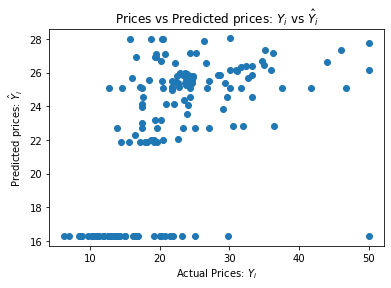

In [10]:
import cupy
import matplotlib.pyplot as plt

# scatter actual and predicted results
plt.scatter(sY_test.to_array(), sY_pred.to_array())

# label graph
plt.xlabel("Actual Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

plt.show()

We can also now visualize our data using the `cuxfilter` library.

In [11]:
reshaped_df = cudf.DataFrame({'x':sY_test.to_array(),'y':sY_pred.to_array()}) 

print(reshaped_df)

        x          y
0    23.8  25.587539
1    15.7  28.014170
2    22.3  25.440471
3    16.6  26.911156
4    17.4  22.744215
..    ...        ...
147  12.8  16.297712
148  23.7  25.268891
149   8.8  16.297712
150  46.7  25.097311
151   9.7  16.297712

[152 rows x 2 columns]


In [12]:
cux_df = DataFrame.from_dataframe(reshaped_df)
# setting pixel_shade_type='linear' to display legend (currently supports only log/linear)
scatter_chart = scatter(x='x',y='y', pixel_shade_type="linear", title='Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$')

d = cux_df.dashboard([scatter_chart])
scatter_chart.view()

Card(sizing_mode='stretch_both', title='Prices vs Predicted p..., width=800)
    [0] Bokeh(Figure)

## Multiple Linear Regression 
- Our mean squared error for Simple Linear Regression looks kinda high.
  - Let's try Multiple Linear Regression (predicting based on multiple variables rather than just `TAX`) and see if that produces more accurate predictions

1. Set X to contain all values that are not `PRICE` from the unsplit data
  - i.e. `CRIM`, `ZN`, `INDUS`, `CHAS`, `NOX`, `RM`, `AGE`, `DIS`, `RAD`, `TAX`, `PTRATIO`, `B`, `LSTAT`
  - Y to still represent just 1 target value (`PRICE`)
    - also from the unsplit data


In [13]:
# set X to all variables except price
mX = bos.drop('PRICE', axis=1)
# and, like in the simple Linear Regression, set Y to price
mY = bos['PRICE']

2. Split the data into `multi_X_train`, `multi_X_test`, `Y_train`, and `Y_test`
  - Use `cuML`'s `train_test_split`
    - And the same 70:30 train:test ratio

In [14]:
# train/test split (70:30)
mX_train, mX_test, mY_train, mY_test = train_test_split(mX, mY, train_size = 0.7)

# see what it looks like
print(mX_train.shape)
print(mX_test.shape)
print(mY_train.shape)
print(mY_test.shape)

(354, 13)
(152, 13)
(354,)
(152,)


3. fit the model with `multi_X_train` and corresponding `PRICE` (*y_train*) values 
  - so it can build an understanding of their relationships 
4. predict `PRICE` (*y_test*) for the test set of independent (*multi_X_test*) values
  - and compare `PRICE` predictions to actual median house (*y_test*) values
    - use `sklearn`'s `mean_squared_error` to do this

In [15]:
# call Linear Regression model
mlr = LinearRegression()

# train the model for multiple regression
mlr.fit(mX_train, mY_train)

# make predictions for test X values
mY_pred = mlr.predict(mX_test)

# calculate error
mmse = mean_squared_error(mY_test.to_array(), mY_pred.to_array())
print(mmse)

33.02223624447847


5. visualize with `matplotlib`

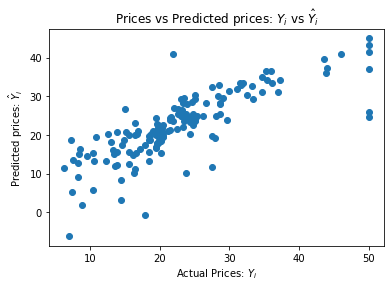

In [16]:
# scatter actual and predicted results
plt.scatter(mY_test.to_array(), mY_pred.to_array())

# label graph
plt.xlabel("Actual Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

plt.show()

We can also now visualize our data using the `cuxfilter` library.

In [17]:
reshaped_df = cudf.DataFrame({'x':mY_test.to_array(),'y':mY_pred.to_array()})

print(reshaped_df)

        x          y
0    18.8  20.208119
1    27.5  19.870132
2    23.3  28.254304
3    12.3  13.141866
4    21.9  23.647163
..    ...        ...
147  21.5  21.315943
148  18.4  19.701479
149  20.4  20.415476
150  23.3  21.971052
151  16.5  11.178304

[152 rows x 2 columns]


In [18]:
cux_df = DataFrame.from_dataframe(reshaped_df)
# setting pixel_shade_type='linear' to display legend (currently supports only log/linear)
scatter_chart = scatter(x='x',y='y', pixel_shade_type="linear", title='Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$')

d = cux_df.dashboard([scatter_chart])
scatter_chart.view()

Card(sizing_mode='stretch_both', title='Prices vs Predicted p..., width=800)
    [0] Bokeh(Figure)

## Conclusion
- looks like the multiple regression we ran does provide more accurate predictions than the simple linear regression
  - this will not always be the case, so always be sure to check and confirm if the extra computing is worth it

Anyways, that's how you implement both Simple and Multiple Linear Regression with `cuML`. Go forth and do great things. Thanks for stopping by!